## Imports

In [78]:
!pip install -q dask[dataframe]

In [131]:
# basicos
import numpy as np
import pandas as pd
import os
import re
import string as s
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import zipfile
from collections import Counter

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize

# scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

# misc
from lightgbm import LGBMClassifier
from wordcloud import WordCloud

In [80]:
# nltk downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

zip_file_path='/root/nltk_data/corpora/wordnet.zip'
extract_dir = os.path.dirname(zip_file_path)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Carregar Dataset

In [81]:
train_data = pd.read_csv('https://raw.githubusercontent.com/Enrico-13/Previsao-de-temas-de-noticias/main/data/train.csv', header=0, names=['id', 'title', 'desc'])
test_data = pd.read_csv('https://raw.githubusercontent.com/Enrico-13/Previsao-de-temas-de-noticias/main/data/test.csv', header=0, names=['id', 'title', 'desc'])

In [82]:
train_data.head()

id                                              title  \
0   3  Wall St. Bears Claw Back Into the Black (Reuters)   
1   3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2   3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3   3  Iraq Halts Oil Exports from Main Southern Pipe...   
4   3  Oil prices soar to all-time record, posing new...   

                                                desc  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...

In [83]:
test_data.head()

id                                              title  \
0   3                  Fears for T N pension after talks   
1   4  The Race is On: Second Private Team Sets Launc...   
2   4      Ky. Company Wins Grant to Study Peptides (AP)   
3   4      Prediction Unit Helps Forecast Wildfires (AP)   
4   4        Calif. Aims to Limit Farm-Related Smog (AP)   

                                                desc  
0  Unions representing workers at Turner   Newall...  
1  SPACE.com - TORONTO, Canada -- A second\team o...  
2  AP - A company founded by a chemistry research...  
3  AP - It's barely dawn when Mike Fitzpatrick st...  
4  AP - Southern California's smog-fighting agenc...

## Personalização do Dataset (união do treino e teste do kaggle)

In [84]:
full_data = pd.concat([train_data, test_data])

In [85]:
full_data.head()

id                                              title  \
0   3  Wall St. Bears Claw Back Into the Black (Reuters)   
1   3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2   3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3   3  Iraq Halts Oil Exports from Main Southern Pipe...   
4   3  Oil prices soar to all-time record, posing new...   

                                                desc  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...

In [86]:
def reduce_data(df, column_name, pct=50):
    # Calcular o fator de redução do dataset
    size_factor = 1 - pct / 100

    # Separar o dataset com estratificação
    _, reduced_df = train_test_split(
        df,
        test_size=size_factor,
        stratify=df[column_name],
        random_state=1309
    )

    return reduced_df.reset_index(drop=True)

In [87]:
full_data = reduce_data(full_data, 'id', pct=50)

## Exploração do Dataset

In [88]:
# shape do dataset
print(full_data.shape)

(63800, 3)


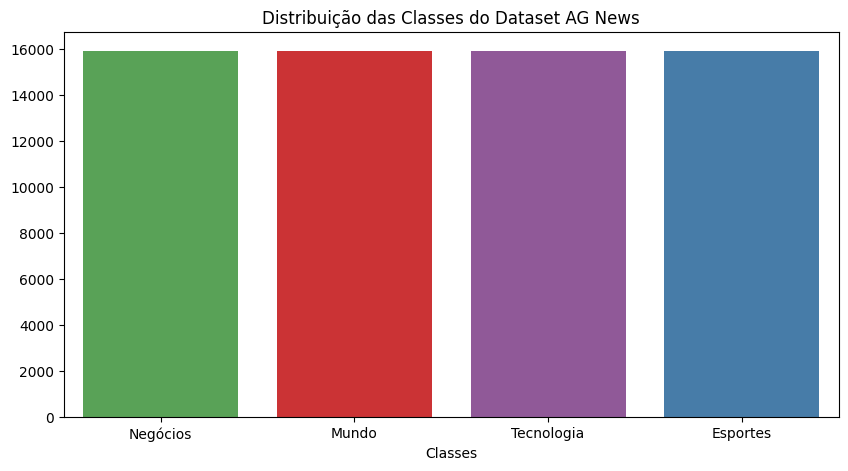

In [89]:
# Countplot das classes no dataset
id_mapping = {
    1: "Mundo",
    2: "Esportes",
    3: "Negócios",
    4: "Tecnologia"
}
plt.figure(figsize=(10, 5))
sns.countplot(x = full_data['id'].map(id_mapping), hue=full_data['id'], legend = False, palette = 'Set1')
plt.title("Distribuição das Classes do Dataset AG News")
plt.ylabel("")
plt.xlabel("Classes")
plt.show()

### Tradução dos valores das classes (campo `id`)
- 1 - Mundo
- 2 - Esportes
- 3 - Negócios
- 4 - Ciência e tecnologia

In [90]:
def word_cloud_displayer(df, column_name, class_id):
    theme = df[df['id'] == class_id][column_name]
    plt.figure(figsize=(10, 8))
    wordcloud = WordCloud(
        min_font_size = 3,
        max_words = 2500,
        width = 1200,
        height = 800
    ).generate(' '.join(theme))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [91]:
def plot_histogram(df, class_id, column_name='id', data_column='title'):
    # Mapeamento das classes
    id_mapping = {
        1: "Mundo",
        2: "Esportes",
        3: "Negócios",
        4: "Tecnologia"
    }

    # Filtra o dataframe para a classe desejada
    class_data = df[df[column_name] == class_id]

    # Concatena todas as palavras da coluna selecionada
    text = ' '.join(class_data[data_column]).split() # Lista todas as palavras
    word_counts = Counter(text)

    # Top 10 mais usadas
    most_common = word_counts.most_common(10)

    # Top 10 menos usadas
    least_common = word_counts.most_common()[:-11:-1]

    # Transforma os dados em dataframes para o plot
    top_df = pd.DataFrame(most_common, columns=['word', 'count'])
    bottom_df = pd.DataFrame(least_common, columns=['word', 'count'])

    # Configurações de plotagem
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.barplot(x='count', y='word', data=top_df, legend=False, hue='word', ax=axes[0], palette='Blues_d')
    axes[0].set_title(f'Top 10 mais usadas - {id_mapping[class_id]}')

    sns.barplot(x='count', y='word', data=bottom_df, legend=False, hue='word', ax=axes[1], palette='Reds_d')
    axes[1].set_title(f'Top 10 menos usadas - {id_mapping[class_id]}')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()


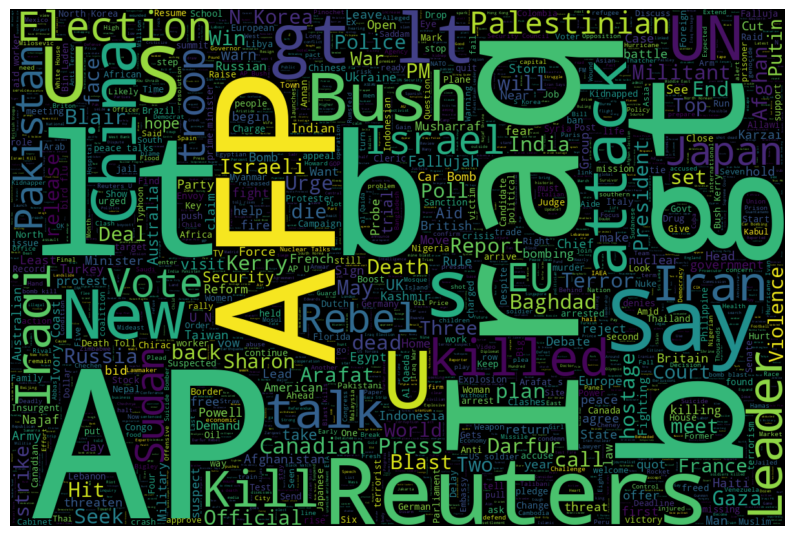

In [92]:
# WordCloud para notícias classificadas como MUNDO

word_cloud_displayer(full_data, 'title', 1)

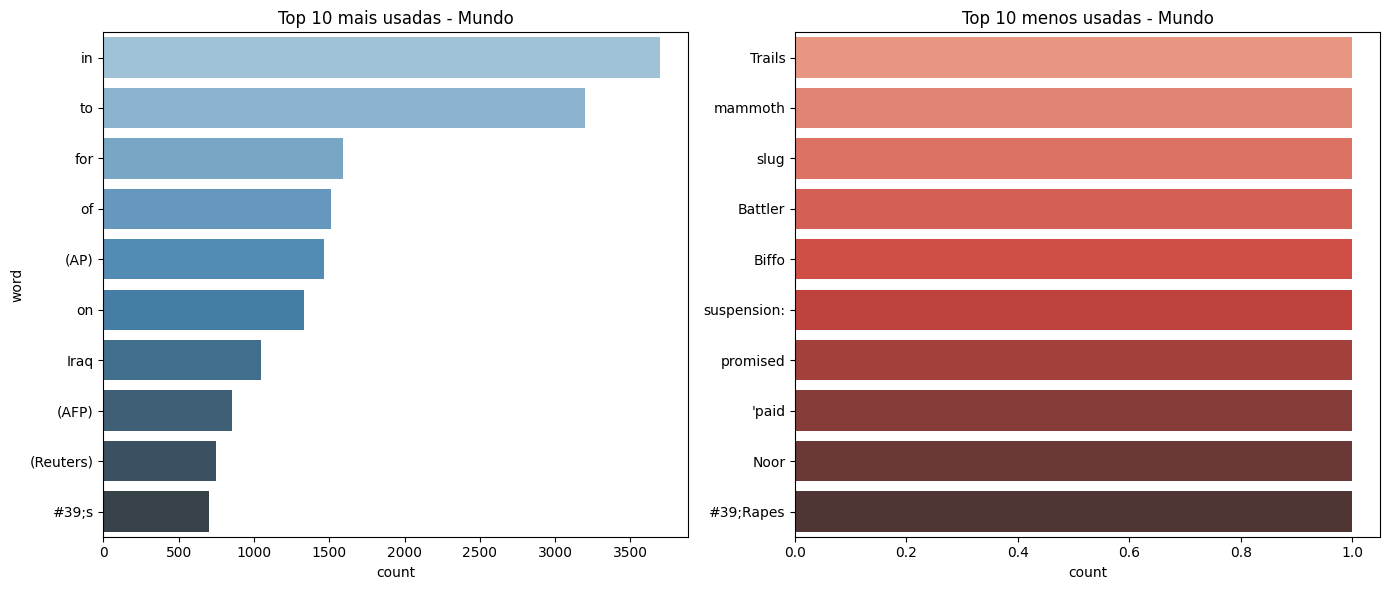

In [93]:
# Countplots para notícias tipo MUNDO

plot_histogram(full_data, 1)

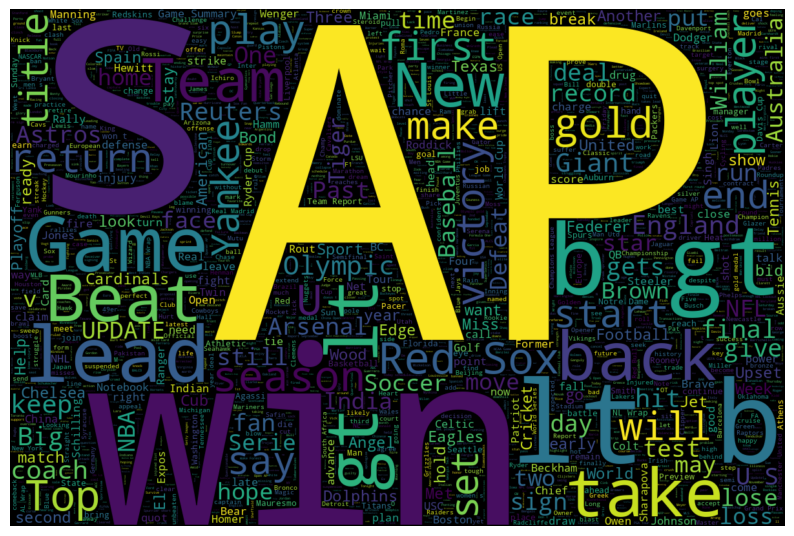

In [94]:
# WordCloud para notícias classificadas como ESPORTES

word_cloud_displayer(full_data, 'title', 2)

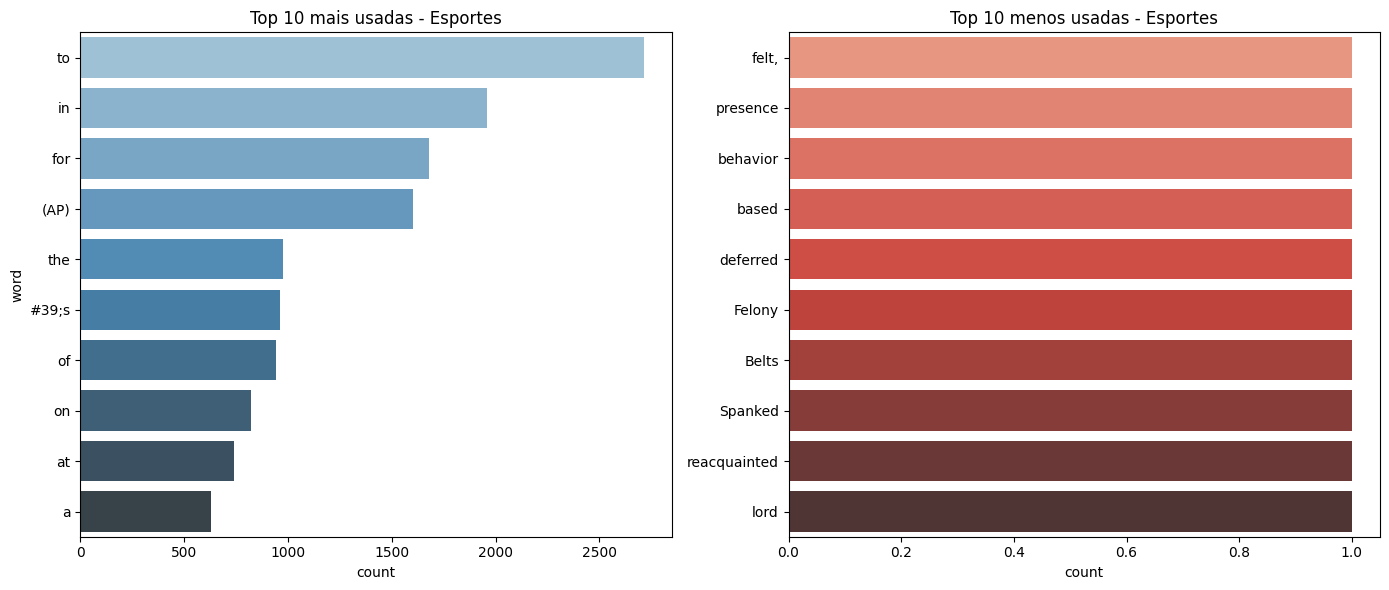

In [95]:
# Countplots para notícias tipo ESPORTES

plot_histogram(full_data, 2)

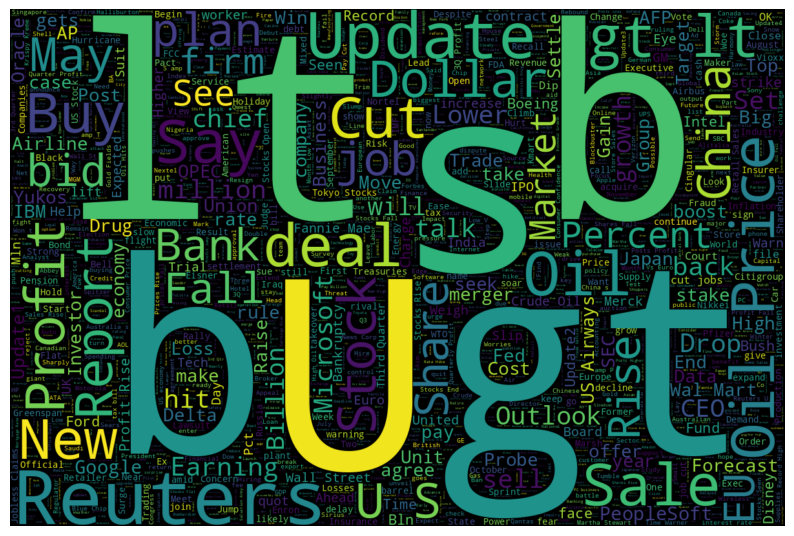

In [96]:
# WordCloud para notícias classificadas como NEGÓCIOS

word_cloud_displayer(full_data, 'title', 3)

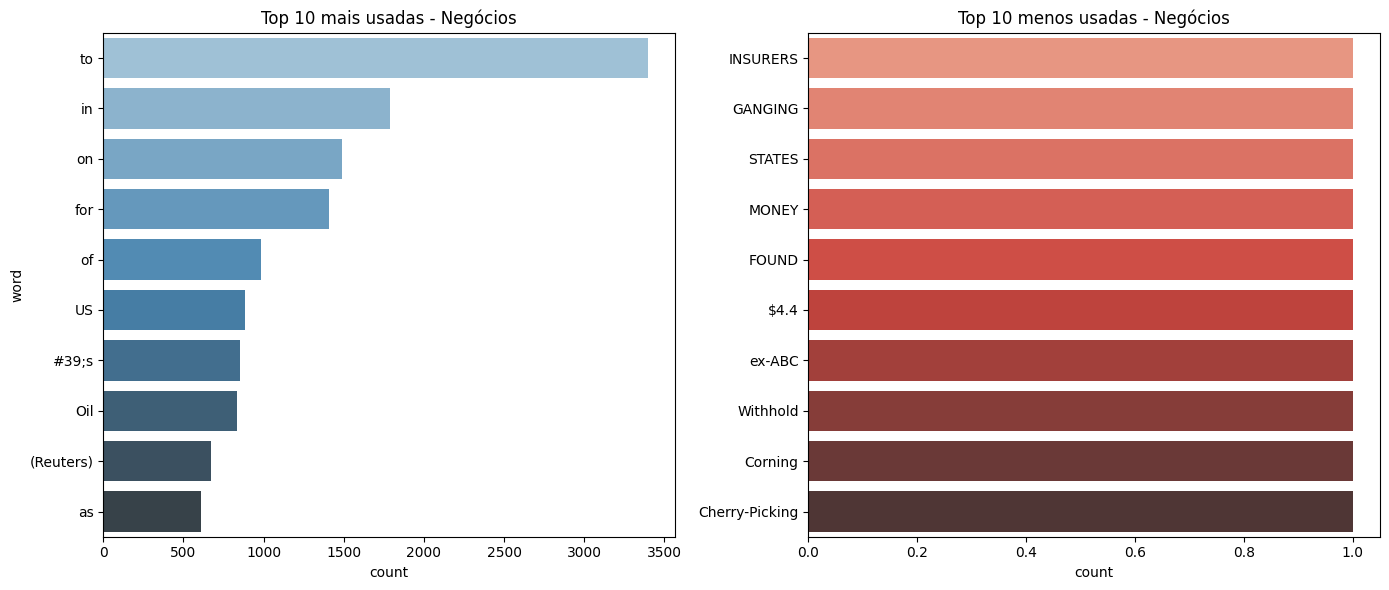

In [97]:
# Countplots para notícias tipo NEGÓCIOS

plot_histogram(full_data, 3)

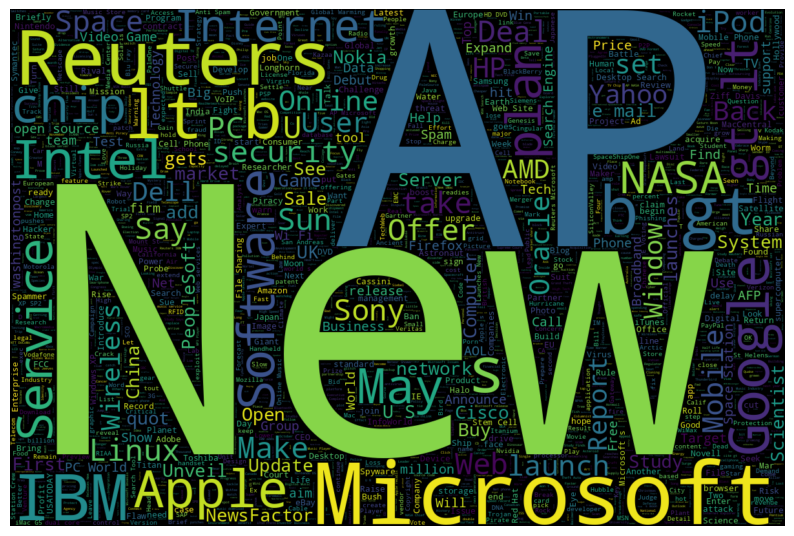

In [98]:
# WordCloud para notícias classificadas como CIÊNCIA E TECNOLOGIA

word_cloud_displayer(full_data, 'title', 4)

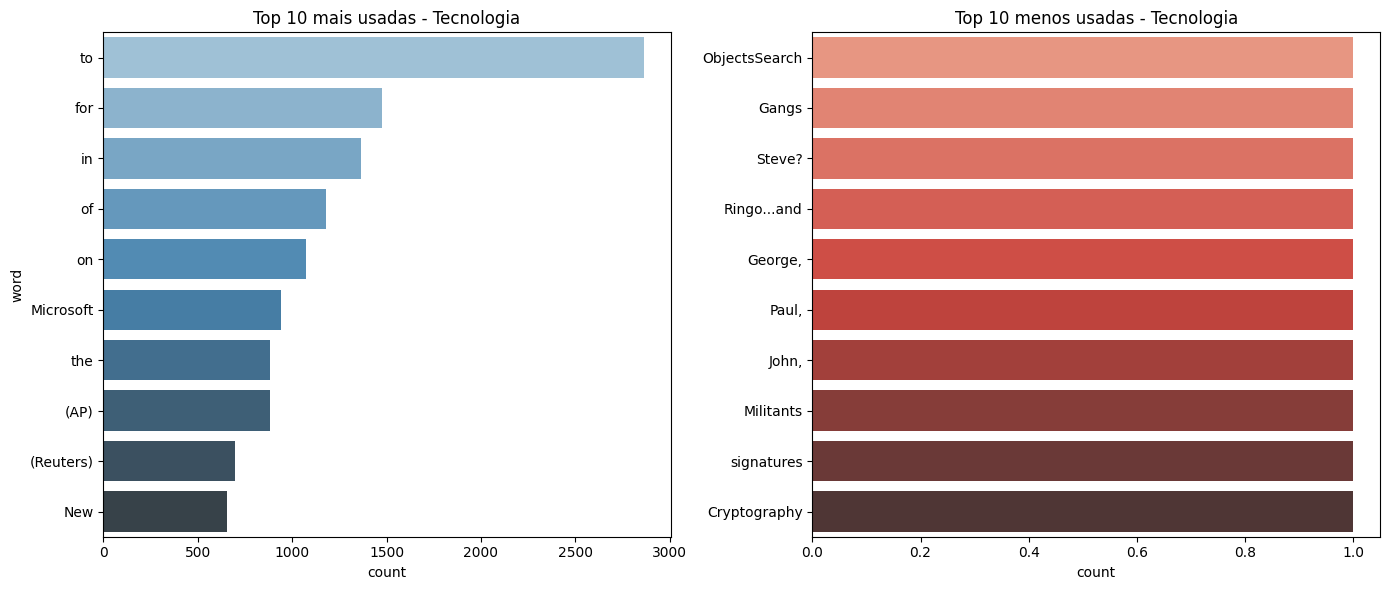

In [99]:
# Countplots para notícias tipo CIÊNCIA E TECNOLOGIA

plot_histogram(full_data, 4)

## Limpeza do dataset

In [100]:
# Remoção de tags HTML
def remove_html(text):
    html = re.compile('<.*?')
    cleaned_text = html.sub('', text)
    return cleaned_text

# Remoção de URLs
def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    cleaned_text = url.sub(r'', text)
    return cleaned_text

# Remoção de stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return [word for word in text if word.lower() not in stop_words]

# Remoção de pontuação
def remove_punct(text):
    return [''.join(char for char in word if char not in s.punctuation) for word in text]

# Removendo números
def remove_numbers(text):
    return [''.join(char for char in word if char not in s.digits) for word in text if word]

# Stemming
def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]

# Lemmatizer
def lemmatizing(text):
    lematizer = WordNetLemmatizer()

    return [lematizer.lemmatize(word) for word in text]

# Removendo palavras extras
def remove_extra(text):
    extra_words = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com', 'ap', 'b b', 'u', 's', 'b']
    return [word for word in text if word not in extra_words]

# Juntando lista de palavras em frases
def join_words(text):
    joined_text = ' '.join(text)
    return joined_text

In [101]:
def data_cleaner(x):
    # remover html
    x = x.apply(remove_html)

    # remover urls
    x = x.apply(remove_urls)

    # tokenizar
    x = x.apply(word_tokenize)

    # passar tudo para minúsculo
    x = x.apply(lambda x: [word.lower() for word in x])

    # remover stopwords
    x = x.apply(remove_stopwords)

    # remover pontuação
    x = x.apply(remove_punct)

    # remover números
    x = x.apply(remove_numbers)

    # realizar stemming ou lemmatizing
    # x = x.apply(stemming)
    x = x.apply(lemmatizing)

    # remover palavras extras
    x = x.apply(remove_extra)

    # juntar arrays em uma frase completa
    x = x.apply(join_words)
    return x

In [102]:
full_data['title'] = data_cleaner(full_data['title'])

In [103]:
full_data

id                                              title  \
0       3                        jpmorgan absorb  ibm worker   
1       3  gabriel resource raise  million private placement   
2       1             iraq donor wrap meeting vow speed fund   
3       1                          hero monster mideast icon   
4       4                          reporting ripoffs seen tv   
...    ..                                                ...   
63795   4                        rfid driver license debated   
63796   4           symantec upgrade norton security product   
63797   1         grenade kill two colombo bollywood concert   
63798   3             fedex boost profit forecast stock jump   
63799   1  indian chinese troop hold mountain exercise re...   

                                                    desc  
0      NEW YORK -- JPMorgan Chase  amp; Co. plans to ...  
1      TORONTO (CP) - Gabriel Resources Ltd. has sign...  
2      Donor nations wrapped up a two-day meeting Thu...  
3      As peace between Israel and the Palestinians w...  
4      Whether it's the latest miracle ab exerciser, ...  
...                                                  ...  
63795  Virginia legislators are weighing a plan to ad...  
63796  Revamped Norton AntiVirus, Personal Firewall, ...  
63797   COLOMBO (Reuters) - Two people were killed an...  
63798  FedEx Corp. (FDX.N: Quote, Profile, Research) ...  
63799  Reuters - Chinese and Indian border troops hav...  

[63800 rows x 3 columns]

## Visualizações do dataset após o pré-processamento

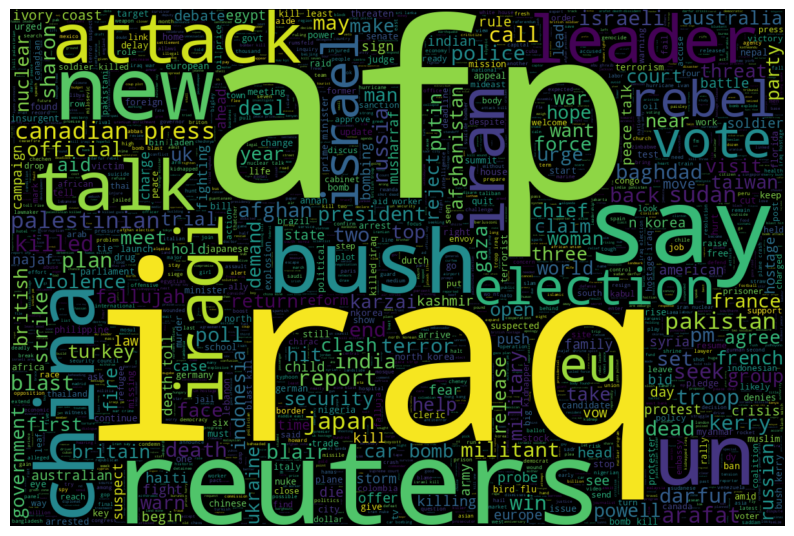

In [104]:
# WordCloud para notícias classificadas como MUNDO

word_cloud_displayer(full_data, 'title', 1)

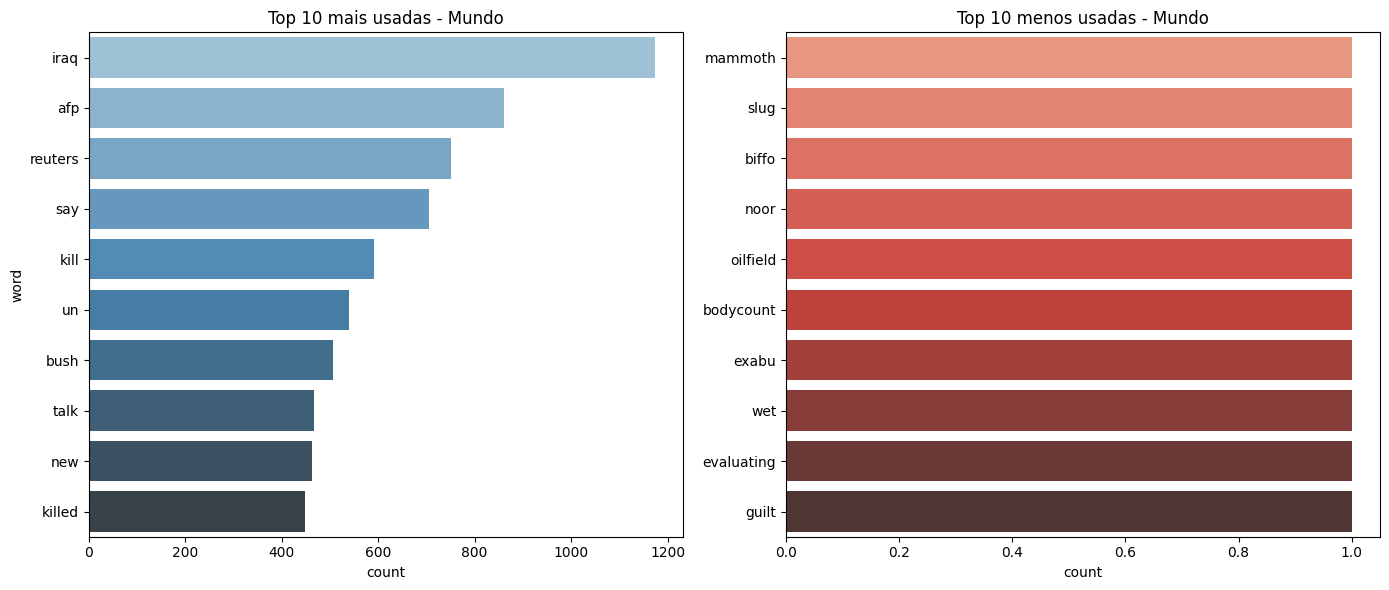

In [105]:
# Countplots para notícias tipo MUNDO

plot_histogram(full_data, 1)

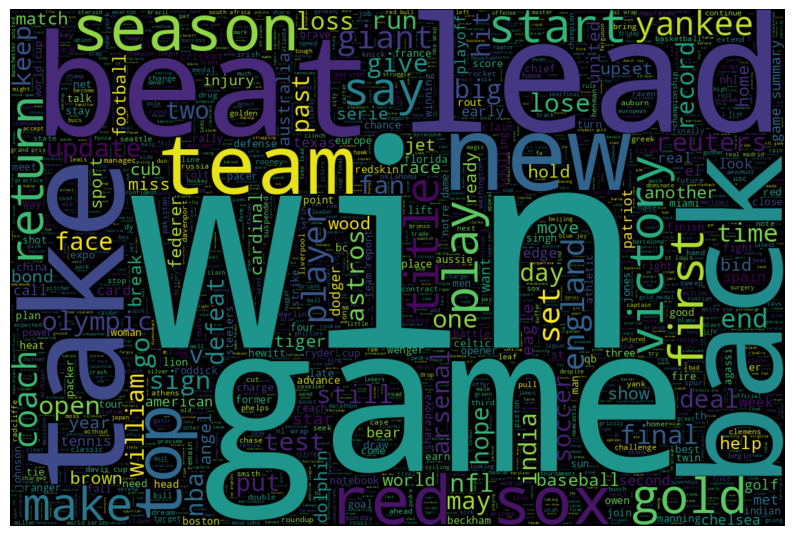

In [106]:
# WordCloud para notícias classificadas como ESPORTES

word_cloud_displayer(full_data, 'title', 2)

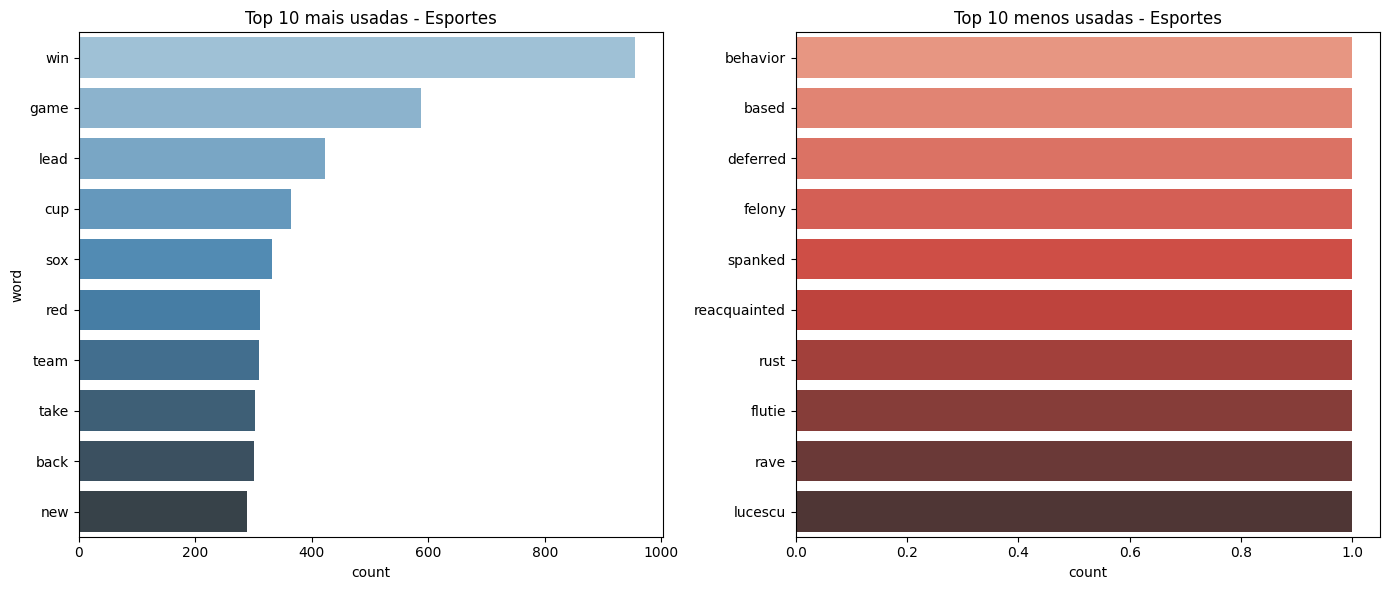

In [107]:
# Countplots para notícias tipo ESPORTES

plot_histogram(full_data, 2)

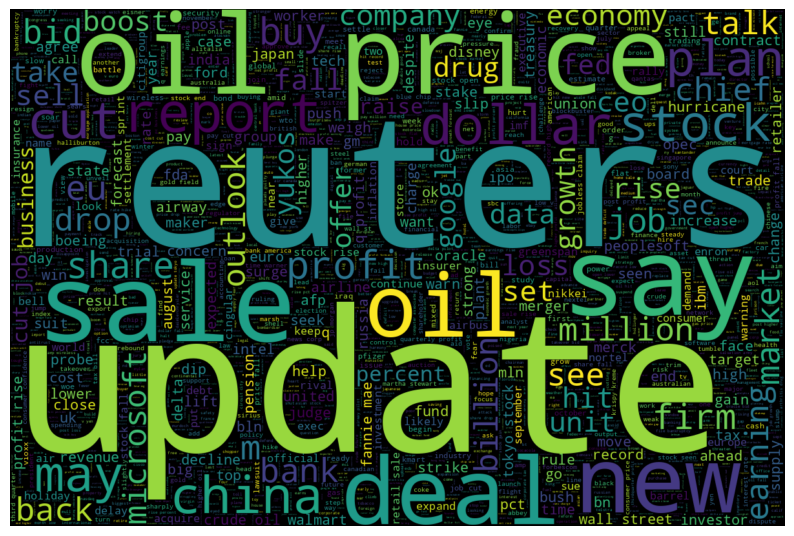

In [108]:
# WordCloud para notícias classificadas como NEGÓCIOS

word_cloud_displayer(full_data, 'title', 3)

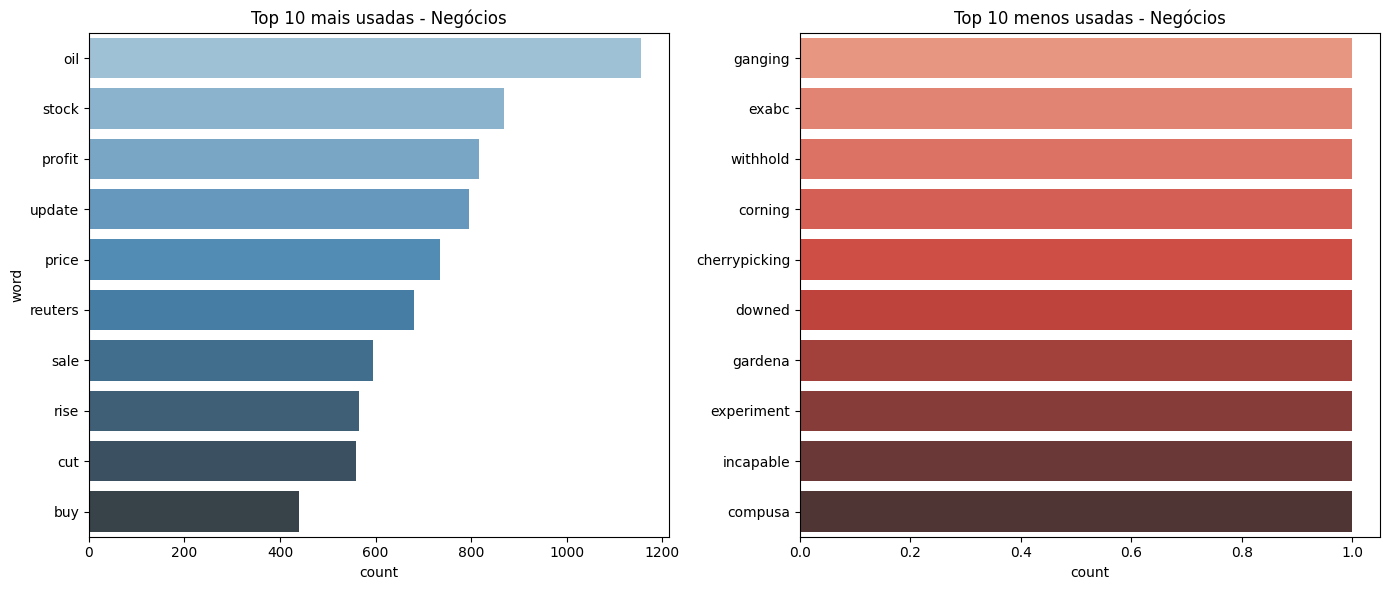

In [109]:
# Countplots para notícias tipo NEGÓCIOS

plot_histogram(full_data, 3)

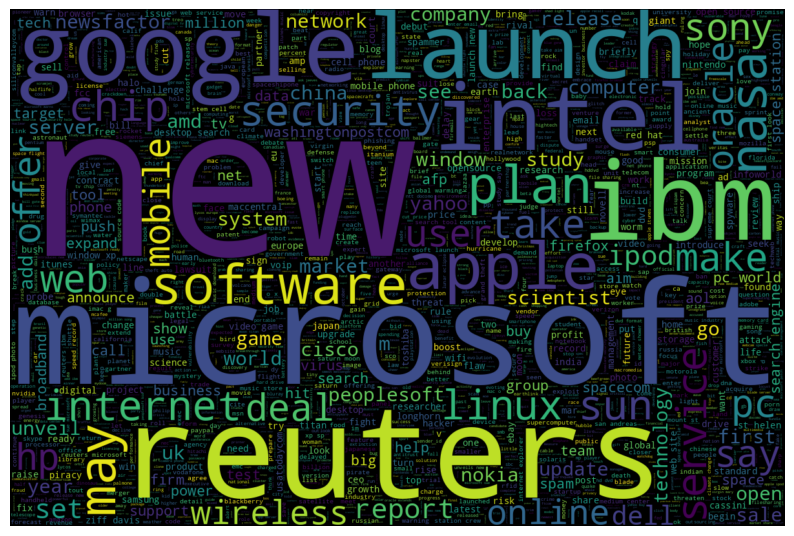

In [110]:
# WordCloud para notícias classificadas como CIÊNCIA E TECNOLOGIA

word_cloud_displayer(full_data, 'title', 4)

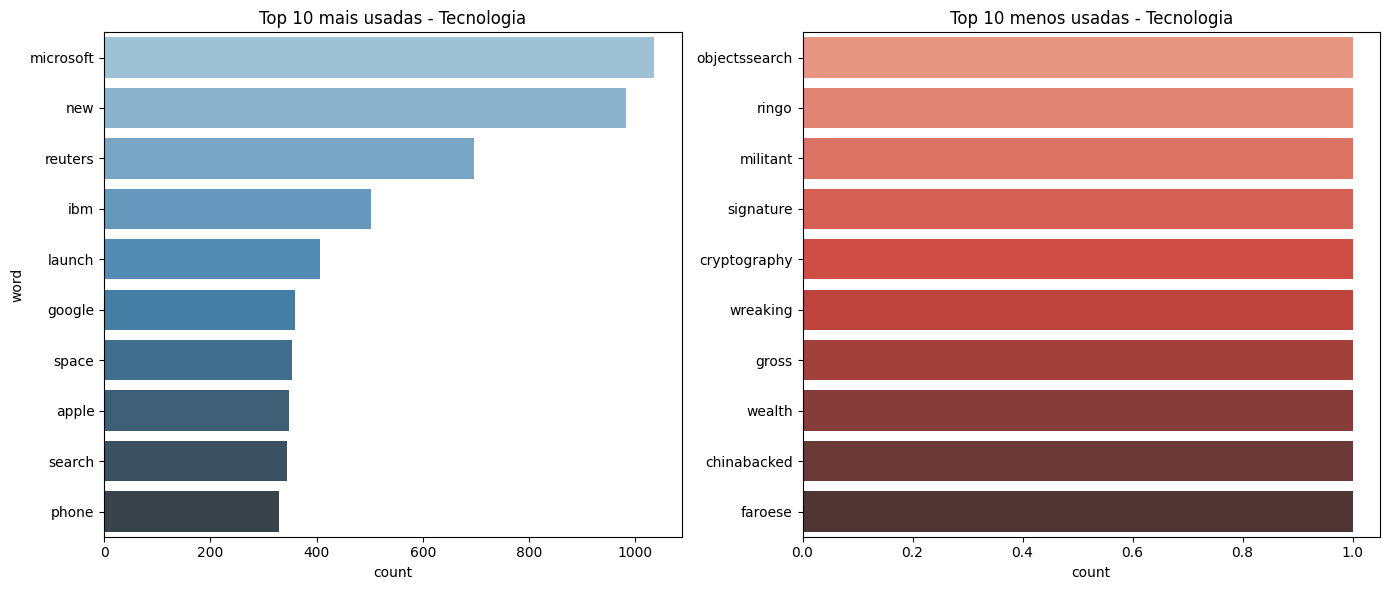

In [111]:
# Countplots para notícias tipo CIÊNCIA E TECNOLOGIA

plot_histogram(full_data, 4)

## Separação do Dataset em treino e teste

In [112]:
train_data, test_data = train_test_split(
    full_data[['id', 'title']],
    test_size=0.2,
    random_state=1309,
    stratify=full_data['id'])

## Separação em X e y

In [113]:
x_train = train_data['title']
x_test = test_data['title']
y_train = train_data['id']
y_test = test_data['id']

## Extração de Features

In [114]:
tfidf = TfidfVectorizer(min_df=8)
train_1 = tfidf.fit_transform(x_train)
test_1 = tfidf.transform(x_test)
print('Número de features extraídas: ')
print(len(tfidf.vocabulary_))
print('Primeiras 100 features: ')
print(list(tfidf.vocabulary_.keys())[:100])
train_arr = train_1.toarray()
test_arr = test_1.toarray()

Número de features extraídas: 
4831
Primeiras 100 features: 
['tape', 'broadcast', 'chinese', 'space', 'capsule', 'hit', 'house', 'unleashes', 'new', 'dvd', 'recorder', 'line', 'wright', 'looking', 'cash', 'freedom', 'state', 'economy', 'point', 'view', 'putin', 'firm', 'bid', 'yukos', 'one', 'killed', 'nepal', 'violence', 'commander', 'iraq', 'insurgent', 'american', 'merck', 'announces', 'withdrawal', 'vioxx', 'painkiller', 'marine', 'face', 'foe', 'fallujah', 'billion', 'power', 'plant', 'job', 'ukrainian', 'opposition', 'make', 'gain', 'samsung', 'electric', 'quarterly', 'profit', 'end', 'attack', 'israel', 'say', 'abbas', 'guide', 'asian', 'betting', 'court', 'consider', 'plea', 'tax', 'bill', 'crunch', 'day', 'gold', 'field', 'move', 'block', 'health', 'deal', 'hughes', 'also', 'nba', 'pioneer', 'comet', 'research', 'dead', 'two', 'baghdad', 'strike', 'sour', 'note', 'england', 'strong', 'wale', 'microsoft', 'provide', 'early', 'warning', 'security', 'flaw', 'endangered', 'specie

In [115]:
feature_names = tfidf.get_feature_names_out()
pd.DataFrame(train_arr[:100], columns=feature_names)

abandon  abbas  abbey  abc  abducted  able  abn  abroad  abu  abuse  ...  \
0       0.0    0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0    0.0  ...   
1       0.0    0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0    0.0  ...   
2       0.0    0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0    0.0  ...   
3       0.0    0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0    0.0  ...   
4       0.0    0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0    0.0  ...   
..      ...    ...    ...  ...       ...   ...  ...     ...  ...    ...  ...   
95      0.0    0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0    0.0  ...   
96      0.0    0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0    0.0  ...   
97      0.0    0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0    0.0  ...   
98      0.0    0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0    0.0  ...   
99      0.0    0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0    0.0  ...   

    zafi  zarqawi  zealand  zero  ziff  zimbabwe  zone  zoo  zook  zurich  
0    0.0      0.0      0.0   0.0   0.0       0.0   0.0  0.0   0.0     0.0  
1    0.0      0.0      0.0   0.0   0.0       0.0   0.0  0.0   0.0     0.0  
2    0.0      0.0      0.0   0.0   0.0       0.0   0.0  0.0   0.0     0.0  
3    0.0      0.0      0.0   0.0   0.0       0.0   0.0  0.0   0.0     0.0  
4    0.0      0.0      0.0   0.0   0.0       0.0   0.0  0.0   0.0     0.0  
..   ...      ...      ...   ...   ...       ...   ...  ...   ...     ...  
95   0.0      0.0      0.0   0.0   0.0       0.0   0.0  0.0   0.0     0.0  
96   0.0      0.0      0.0   0.0   0.0       0.0   0.0  0.0   0.0     0.0  
97   0.0      0.0      0.0   0.0   0.0       0.0   0.0  0.0   0.0     0.0  
98   0.0      0.0      0.0   0.0   0.0       0.0   0.0  0.0   0.0     0.0  
99   0.0      0.0      0.0   0.0   0.0       0.0   0.0  0.0   0.0     0.0  

[100 rows x 4831 columns]

# Naive Bayes

## Cálculo

In [134]:
%%time
nb_multi = MultinomialNB()
param_dist = {
    'alpha': np.linspace(0.0, 1.0, 100),
    'fit_prior': [False]
}
random_search = RandomizedSearchCV(
    estimator=nb_multi,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    random_state=1309,
    n_jobs=1
)
random_search.fit(train_arr, y_train)

CPU times: user 3min 36s, sys: 1min 20s, total: 4min 57s
Wall time: 3min 45s


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=30, n_jobs=1,
                   param_distributions={'alpha': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0....
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747475,
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                                        'fit_prior': [False]},
                   random_state=1309, scoring='accuracy')

In [135]:
# Avaliação do melhor modelo
best_model = random_search.best_estimator_
y_pred = best_model.predict(test_arr)

In [136]:
print("Primeiras 20 classes reais")
print(y_test.tolist()[:20])
print("primeiras 20 classes calculadas")
print(y_pred.tolist()[:20])

Primeiras 20 classes reais
[3, 2, 4, 3, 3, 2, 1, 2, 3, 4, 4, 2, 1, 1, 2, 4, 4, 2, 3, 3]
primeiras 20 classes calculadas
[3, 2, 4, 3, 3, 2, 1, 2, 3, 1, 4, 2, 1, 1, 2, 3, 3, 2, 3, 3]


## Métricas

In [137]:
print('F1 score do NB')
f1 = f1_score(y_test, y_pred, average='micro')
print(f1)
print('Acurácia do NB')
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
accuracy_pct = round(accuracy * 100, 3)
print(accuracy_pct, "%")

F1 score do NB
0.8334639498432602
Acurácia do NB
0.8334639498432602
83.346 %


In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.85      0.84      3190
           2       0.87      0.88      0.87      3190
           3       0.81      0.80      0.81      3190
           4       0.82      0.81      0.81      3190

    accuracy                           0.83     12760
   macro avg       0.83      0.83      0.83     12760
weighted avg       0.83      0.83      0.83     12760



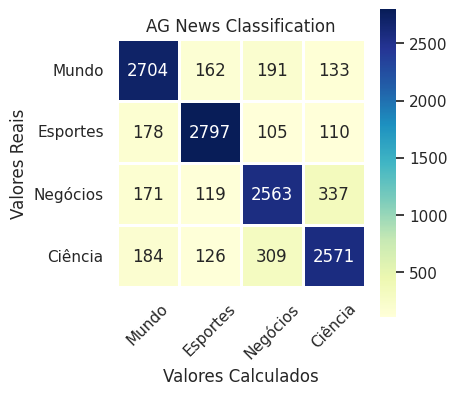

In [139]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index = ['Mundo', 'Esportes', 'Negócios', 'Ciência'],
    columns = ['Mundo', 'Esportes', 'Negócios', 'Ciência']
)
sns.set(font_scale=1)
plt.figure(figsize=(4, 4))
sns.heatmap(
    conf_matrix_df,
    cmap = 'YlGnBu',
    linewidths = 1,
    annot = True,
    square = True,
    cbar = True,
    fmt = 'd'
)
plt.xlabel('Valores Calculados')
plt.ylabel('Valores Reais')
plt.title('AG News Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [140]:
def plot_learning_curve(estimator, x, y, cv=None):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 100)
    )

    # Cálculo de média e desvio padrão do treino e teste
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Treinamento')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Teste')

    # Mostrar desvio padrão
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')

    plt.xlabel('Tamanho do Conjunto de Treinamento')
    plt.ylabel('Pontuação')
    plt.title('Curvas de Aprendizagem')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

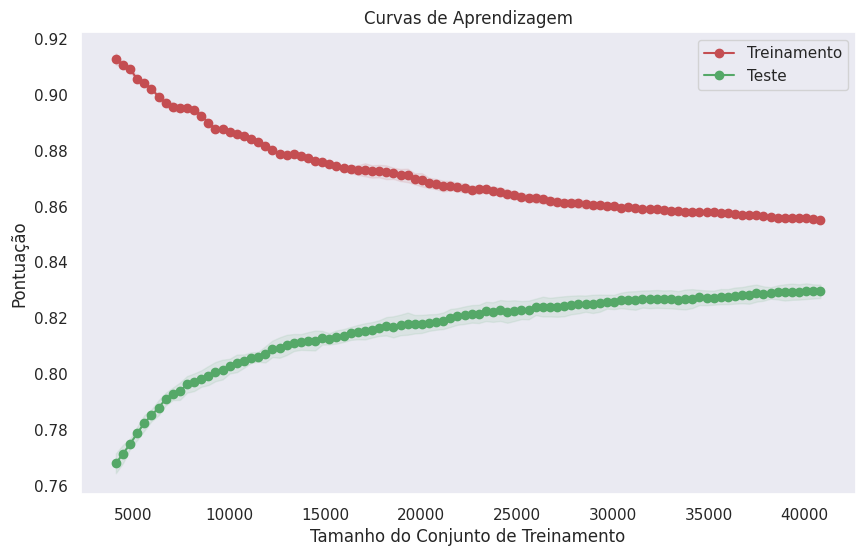

In [141]:
plot_learning_curve(best_model, train_arr, y_train, cv=5)